# $k$NN Classifiers

In class, we saw that using $k$NN density estimation leads to a simple rule for classification: draw a ball of radius $r_k(x)$ around $x$, and return the label that occurs most often within the ball. This notebook will implement this simple idea.

In [1]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)

## Moon data

`sklearn` comes with some data out of the box. The following code generates two crescent moons, with some noise:

In [2]:
moons_features_array, moons_labels = sklearn.datasets.make_moons(200, noise=.3)

`moons_features_array` is a 2-d NumPy array. You have experience working with 1-d NumPy arrays from DSC 10, but maybe not so much practice with 2-d arrays, so I'll go ahead and convert it to a list of 1-d arrays right off the bat:

In [3]:
moons_features = list(moons_features_array)

`moons_labels` is a 1-d array of labels (either 0 or 1), telling us which crescent moon the point belongs to.

In [4]:
moons_labels

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1])

Let's take a look at the data:

In [5]:
moons_x_1, moons_x_2 = moons_features_array.T

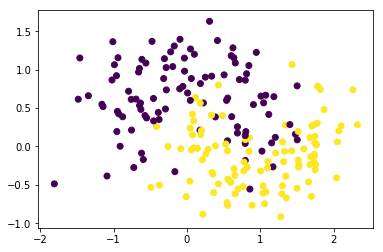

In [6]:
plt.scatter(moons_x_1, moons_x_2, c=moons_labels)

A yellow point has label 1, while a purple point has label 0.

## The Classifier

Now we write a function which will take in a point z, along with the data, and return a predicted label. The first thing the function must do is find all points which are within radius $r_k(z)$ of z; that is, it finds the $k$ closest points.

In [7]:
def k_closest_points(z, features, k=3):
    """Find the k closest points to z in the features.
    
    Returns a list of pairs. Each pair contains:
    
        (distance to z, index of point)
    
    """
    # find the distance from z to every point
    distances = []
    for ix, x in enumerate(features):
        distance = np.sum((x - z)**2)**(1/2)
        distances.append((distance, ix))
    
    return sorted(distances)[:k]

Let's check and make sure this function is doing what we expect. The below will plot the point $z$ in red, a circle of radius $r_k(z)$ around $z$, and all points within the circle in orange. Try changing $z$ and $k$ and see what happens.

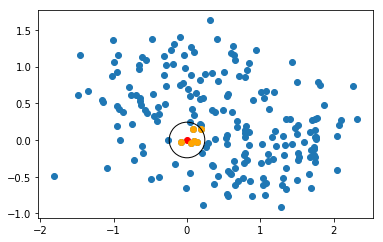

In [8]:
z = [0, 0]
k = 6

plt.scatter(moons_x_1, moons_x_2)
plt.scatter(*z, color='red')

closest = k_closest_points(z, moons_features, k=k)

for _, ix in closest:
    x, y = moons_features[ix]
    plt.scatter(x, y, color='orange')
    
r = closest[-1][0]
circle = plt.Circle(z, r, fill=False)
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal')

Now we can write our classifier function. It should return the label that is found most frequently within the circle. Because the labels are either 0 or 1 here, this amounts to summing up the labels and returning 1 if the sum  is greater than k/2. Try changing $z$ and $k$ and see what happens.

In [9]:
def knn_classify(z, features, labels, k=3):
    closest = k_closest_points(z, features, k)
    votes = [labels[ix] for _,ix in closest]
    return int(sum(votes) > k/2)

Prediction: 0


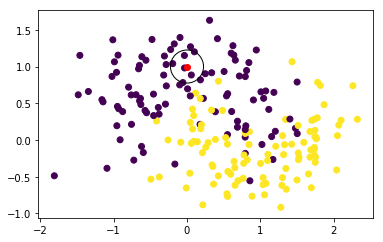

In [10]:
z = [0, 1]
k = 6

plt.scatter(moons_x_1, moons_x_2, c=moons_labels)
plt.scatter(*z, color='red')

closest = k_closest_points(z, moons_features, k=k)
    
r = closest[-1][0]
circle = plt.Circle(z, r, fill=False)
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal')

prediction = knn_classify(z, moons_features, moons_labels, k=k)
print('Prediction:', prediction)

## MNIST data

Now let's look at a slightly larger and more interesting dataset: the MNIST handwritten image dataset. We'll use this as an opportunity to re-write the kNN classifier "correctly", using fast NumPy functions.

In [70]:
mnist_data = np.load('mnist.npz')
mnist_train_features = mnist_data['train'].T.astype(float)
mnist_train_labels = mnist_data['train_labels'].flatten()
mnist_test_features = mnist_data['test'].T.astype(float)
mnist_test_labels = mnist_data['test_labels'].flatten()

Our data is now in a $60,000 \times 784$ array. There are 60,000 examples, each being a 784-dimensional vector.

In [71]:
mnist_train_features.shape

(60000, 784)

In [72]:
mnist_train_features[0]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,   51.,

Each of these vectors is actually a 28x28 image, "flattened" into a vector. We can reshape and visualize it:

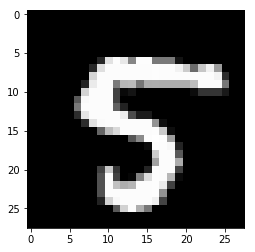

In [73]:
plt.imshow(mnist_train_features[33_000].reshape(28, -1), cmap='gray')

## The (fast) classifier

Now we will re-write `k_closest_points` and `knn_classify` above, but faster.

In [74]:
import scipy.spatial.distance

def fast_k_closest_points(z, features, k=3):
    distances = scipy.spatial.distance_matrix([z], features).flatten()
    return np.argpartition(distances, k)[:k]

Let's try it out. We saw that vector #33,000 is a five. What are its closest neighbors?

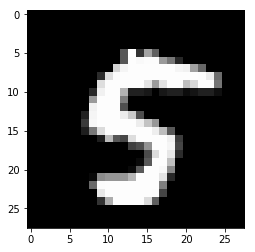

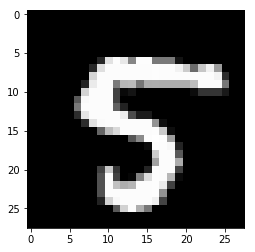

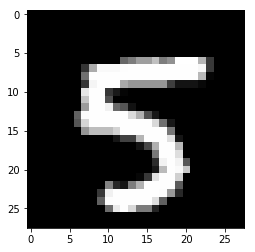

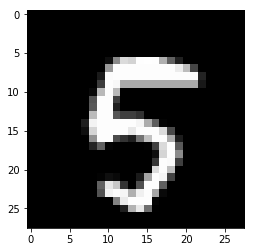

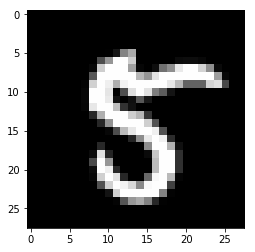

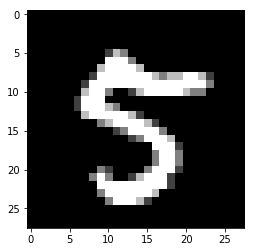

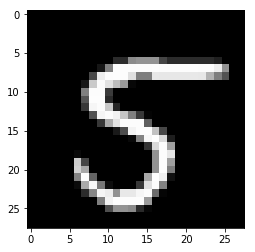

In [75]:
closest = fast_k_closest_points(mnist_train_features[33_000], mnist_train_features, k=7)
for ix in closest:
    plt.figure()
    plt.imshow(mnist_train_features[ix].reshape(28, -1), cmap='gray')

In [76]:
def fast_knn_classifier(z, features, labels, k=5):
    closest_ix = fast_k_closest_points(z, features, k)
    closest_labels = labels[closest_ix]
    values, counts = np.unique(closest_labels, return_counts=True)
    return values[np.argmax(counts)]

Let's try it out on unseen data:

Prediction: 6.0


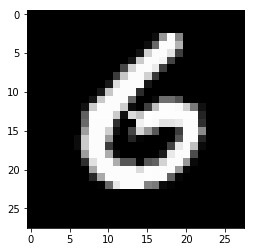

In [82]:
ix = 6500

plt.imshow(mnist_test_features[ix].reshape(-1, 28), cmap='gray')

prediction = fast_knn_classifier(
    mnist_test_features[ix], 
    mnist_train_features, 
    mnist_train_labels
)

print('Prediction:', prediction)

We now run the classifier on 100 random unseen examples. How many does it get right?

In [85]:
correct = 0
for i in range(100):
    ix = np.random.randint(len(mnist_test_features))
    prediction = fast_knn_classifier(
        mnist_test_features[ix], 
        mnist_train_features, 
        mnist_train_labels
    )
    if prediction == mnist_test_labels[ix]:
        correct += 1

In [86]:
correct

96